# Temporal Dynamics Analysis - {TIMEFRAME}-decision

**Purpose**: Identify WHEN gaze and pupil patterns diverge by decision outcome (INVEST vs KEEP).

**Method**: 
- Use the already-extracted features to analyze patterns
- Compare {TIMEFRAME}-decision (-2 to 0s) vs {TIMEFRAME}-decision (0 to +2s) windows
- Statistical tests to show divergence

**Key Question**: Do {TIMEFRAME}-decision signals predict the upcoming choice?

**Parameterized**: Set `TIMEFRAME` to run PRE or POST analysis.

In [10]:
# ============================================================================
# CONFIGURATION: Set timeframe for analysis
# ============================================================================
TIMEFRAME = 'PRE'  # Options: 'PRE', 'POST'
# ============================================================================

print(f"\n{'='*70}")
print(f"TEMPORAL DYNAMICS ANALYSIS: {TIMEFRAME}-DECISION PERIOD")
print(f"{'='*70}\n")


TEMPORAL DYNAMICS ANALYSIS: PRE-DECISION PERIOD



In [11]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

## Load PRE-Decision Features

In [12]:
# Load PRE-decision features
with open(f'../../data/results/features_{TIMEFRAME}/extracted_features_{TIMEFRAME}.pkl', 'rb') as f:
    feature_data = pickle.load(f)

data_pre = feature_data['merged_df']

print(f"PRE-decision data: {len(data_pre)} trials")
print(f"Subjects: {data_pre['subject_id'].nunique()}")
print(f"\nOutcome distribution:")
print(data_pre['outcome'].value_counts())

PRE-decision data: 12511 trials
Subjects: 97

Outcome distribution:
outcome
1    8238
0    4273
Name: count, dtype: int64


## Compare Feature Distributions by Outcome

We'll analyze how {TIMEFRAME}-decision features differ between INVEST vs KEEP choices.

In [13]:
# Separate by outcome
invest_trials = data_pre[data_pre['outcome'] == 1]
keep_trials = data_pre[data_pre['outcome'] == 0]

print(f"INVEST trials: {len(invest_trials)}")
print(f"KEEP trials: {len(keep_trials)}")

INVEST trials: 8238
KEEP trials: 4273


## Key Pupil Features Comparison

In [14]:
# Select key pupil features
pupil_features = [
    'pupil_mean_pre',
    'pupil_std_pre', 
    'pupil_slope_pre',
    'pupil_velocity_mean_pre'
]

# Compute statistics
comparison_results = []

for feature in pupil_features:
    invest_vals = invest_trials[feature].dropna()
    keep_vals = keep_trials[feature].dropna()
    
    # T-test
    t_stat, p_val = stats.ttest_ind(invest_vals, keep_vals)
    
    # Effect size (Cohen's d)
    cohens_d = (invest_vals.mean() - keep_vals.mean()) / np.sqrt(
        ((len(invest_vals)-1)*invest_vals.std()**2 + (len(keep_vals)-1)*keep_vals.std()**2) / 
        (len(invest_vals) + len(keep_vals) - 2)
    )
    
    comparison_results.append({
        'feature': feature,
        'invest_mean': invest_vals.mean(),
        'keep_mean': keep_vals.mean(),
        'difference': invest_vals.mean() - keep_vals.mean(),
        't_statistic': t_stat,
        'p_value': p_val,
        'cohens_d': cohens_d,
        'significant': 'Yes' if p_val < 0.05 else 'No'
    })

pupil_comparison_df = pd.DataFrame(comparison_results)
print("\n" + "="*80)
print("PUPIL FEATURES: INVEST vs KEEP (PRE-decision)")
print("="*80)
print(pupil_comparison_df.to_string(index=False))


PUPIL FEATURES: INVEST vs KEEP (PRE-decision)
                feature  invest_mean  keep_mean  difference  t_statistic      p_value  cohens_d significant
         pupil_mean_pre     0.429538   0.396246    0.033292     5.671508 1.446817e-08  0.106922         Yes
          pupil_std_pre     0.653087   0.552884    0.100204    13.954635 6.289924e-44  0.263080         Yes
        pupil_slope_pre    -0.752771  -0.398010   -0.354760   -17.656323 6.223602e-69 -0.332866         Yes
pupil_velocity_mean_pre     0.033633   0.030930    0.002703     8.838090 1.102819e-18  0.166620         Yes


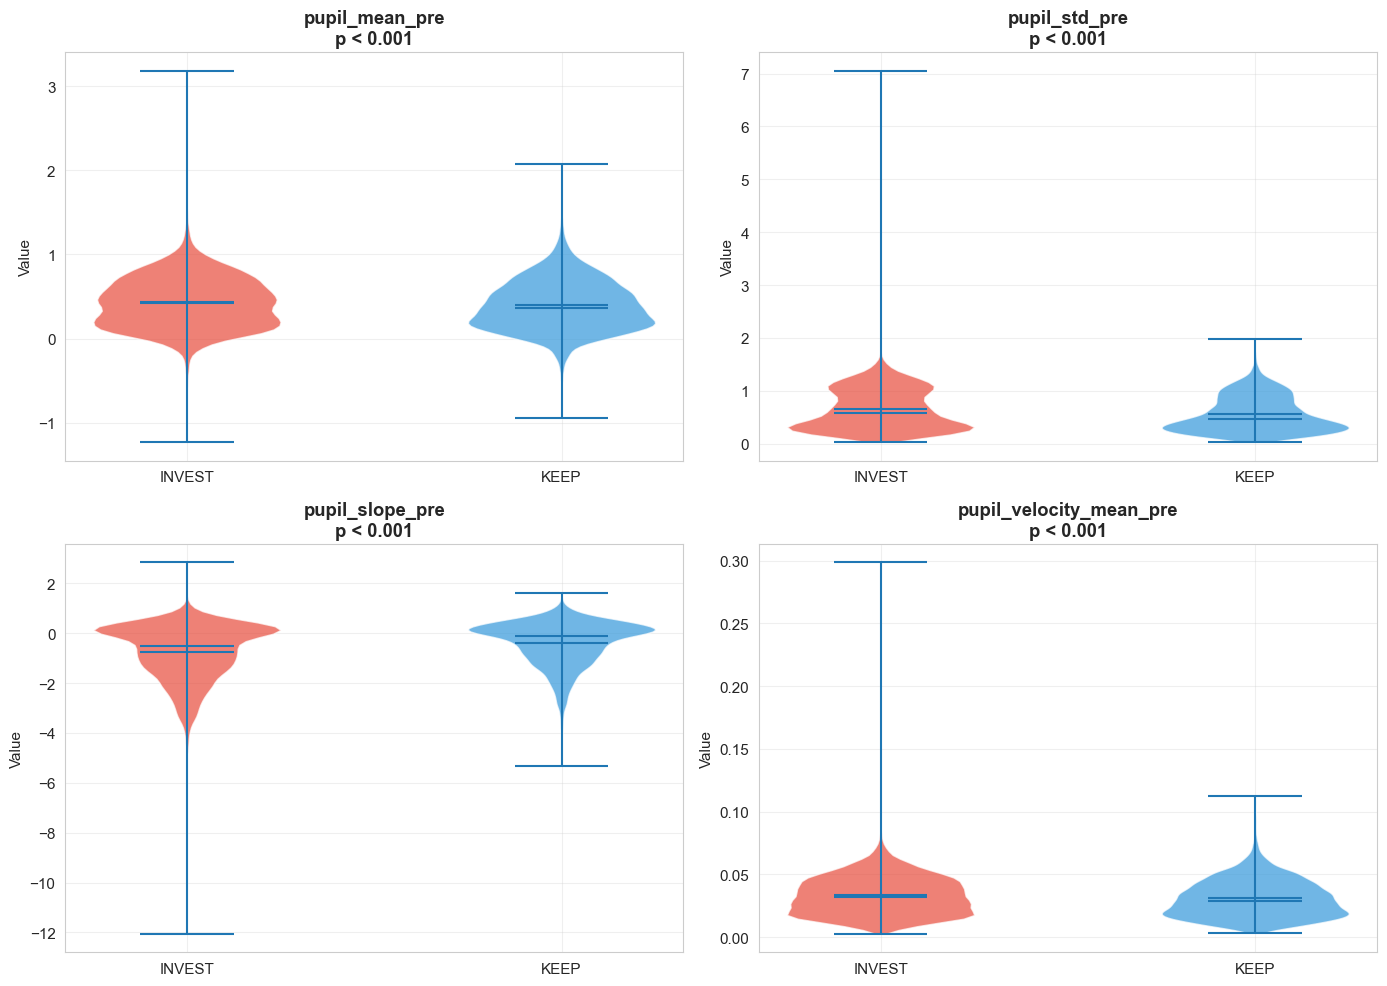

In [15]:
# Visualize pupil feature distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, feature in enumerate(pupil_features):
    ax = axes[idx]
    
    # Violin plot
    parts = ax.violinplot(
        [invest_trials[feature].dropna(), keep_trials[feature].dropna()],
        positions=[1, 2],
        showmeans=True,
        showmedians=True
    )
    
    # Color the violins
    parts['bodies'][0].set_facecolor('#E74C3C')
    parts['bodies'][0].set_alpha(0.7)
    parts['bodies'][1].set_facecolor('#3498DB')
    parts['bodies'][1].set_alpha(0.7)
    
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['INVEST', 'KEEP'])
    
    # Add p-value
    p_val = pupil_comparison_df[pupil_comparison_df['feature'] == feature]['p_value'].values[0]
    sig_text = f"p = {p_val:.4f}" if p_val >= 0.001 else "p < 0.001"
    ax.set_title(f"{feature}\n{sig_text}", fontweight='bold')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'../../data/results/analysis_outputs_{TIMEFRAME}/pupil_feature_comparison_{TIMEFRAME}.png', 
            dpi=300, bbox_inches='tight')
plt.show()

## Key Gaze Features Comparison

In [16]:
# Select key gaze features
gaze_features = [
    'fixation_ratio',
    'saccade_count',
    'gaze_velocity_mean',
    'gaze_dispersion_x'
]

# Compute statistics
gaze_comparison_results = []

for feature in gaze_features:
    invest_vals = invest_trials[feature].dropna()
    keep_vals = keep_trials[feature].dropna()
    
    # T-test
    t_stat, p_val = stats.ttest_ind(invest_vals, keep_vals)
    
    # Effect size (Cohen's d)
    cohens_d = (invest_vals.mean() - keep_vals.mean()) / np.sqrt(
        ((len(invest_vals)-1)*invest_vals.std()**2 + (len(keep_vals)-1)*keep_vals.std()**2) / 
        (len(invest_vals) + len(keep_vals) - 2)
    )
    
    gaze_comparison_results.append({
        'feature': feature,
        'invest_mean': invest_vals.mean(),
        'keep_mean': keep_vals.mean(),
        'difference': invest_vals.mean() - keep_vals.mean(),
        't_statistic': t_stat,
        'p_value': p_val,
        'cohens_d': cohens_d,
        'significant': 'Yes' if p_val < 0.05 else 'No'
    })

gaze_comparison_df = pd.DataFrame(gaze_comparison_results)
print("\n" + "="*80)
print("GAZE FEATURES: INVEST vs KEEP (PRE-decision)")
print("="*80)
print(gaze_comparison_df.to_string(index=False))


GAZE FEATURES: INVEST vs KEEP (PRE-decision)
           feature  invest_mean  keep_mean  difference  t_statistic  p_value  cohens_d significant
    fixation_ratio     0.997510   0.997789   -0.000280    -1.252273 0.210494 -0.023608          No
     saccade_count     0.363559   0.366721   -0.003162    -0.097962 0.921964 -0.001847          No
gaze_velocity_mean     0.627545   0.588485    0.039060     1.252368 0.210459  0.023610          No
 gaze_dispersion_x     0.264187   0.284576   -0.020389    -3.473446 0.000516 -0.065483         Yes


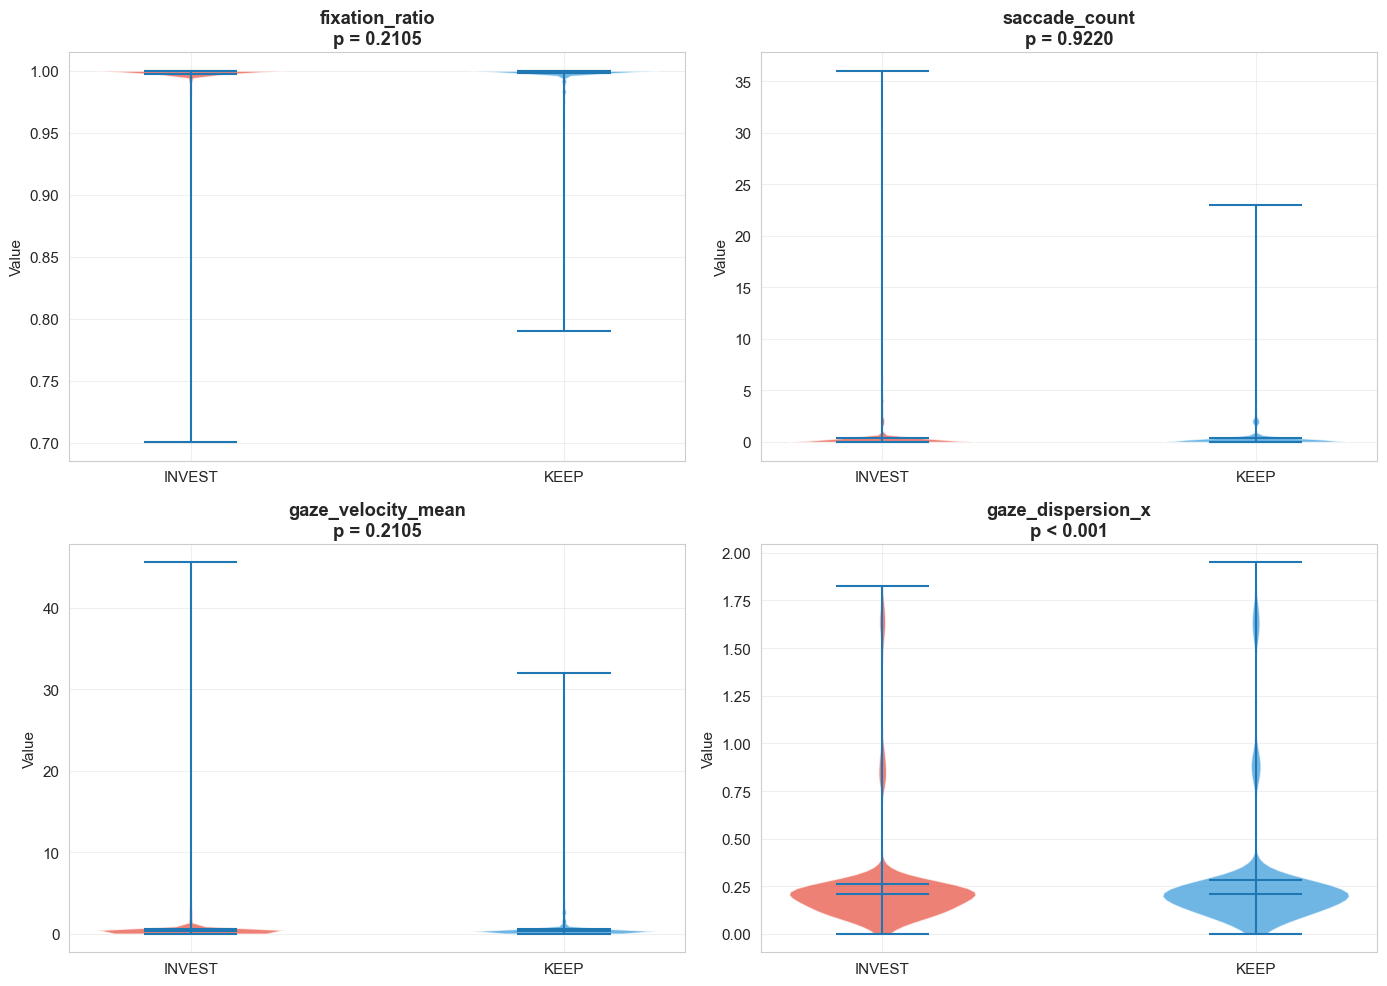

In [17]:
# Visualize gaze feature distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, feature in enumerate(gaze_features):
    ax = axes[idx]
    
    # Violin plot
    parts = ax.violinplot(
        [invest_trials[feature].dropna(), keep_trials[feature].dropna()],
        positions=[1, 2],
        showmeans=True,
        showmedians=True
    )
    
    # Color the violins
    parts['bodies'][0].set_facecolor('#E74C3C')
    parts['bodies'][0].set_alpha(0.7)
    parts['bodies'][1].set_facecolor('#3498DB')
    parts['bodies'][1].set_alpha(0.7)
    
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['INVEST', 'KEEP'])
    
    # Add p-value
    p_val = gaze_comparison_df[gaze_comparison_df['feature'] == feature]['p_value'].values[0]
    sig_text = f"p = {p_val:.4f}" if p_val >= 0.001 else "p < 0.001"
    ax.set_title(f"{feature}\n{sig_text}", fontweight='bold')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'../../data/results/analysis_outputs_{TIMEFRAME}/gaze_feature_comparison_{TIMEFRAME}.png', 
            dpi=300, bbox_inches='tight')
plt.show()

## Save Results Summary

In [18]:
# Combine results
all_comparison_df = pd.concat([pupil_comparison_df, gaze_comparison_df], ignore_index=True)

# Sort by effect size
all_comparison_df = all_comparison_df.sort_values('cohens_d', key=abs, ascending=False)

# Save
output_dir = Path('../../data/results/analysis_outputs_PRE')
output_dir.mkdir(parents=True, exist_ok=True)

all_comparison_df.to_csv(output_dir / f'temporal_dynamics_summary_{TIMEFRAME}.csv', index=False)

print("\n" + "="*80)
print("TEMPORAL DYNAMICS SUMMARY (Sorted by Effect Size)")
print("="*80)
print(all_comparison_df.to_string(index=False))
print(f"\n✓ Summary saved to: temporal_dynamics_summary_{TIMEFRAME}.csv")


TEMPORAL DYNAMICS SUMMARY (Sorted by Effect Size)
                feature  invest_mean  keep_mean  difference  t_statistic      p_value  cohens_d significant
        pupil_slope_pre    -0.752771  -0.398010   -0.354760   -17.656323 6.223602e-69 -0.332866         Yes
          pupil_std_pre     0.653087   0.552884    0.100204    13.954635 6.289924e-44  0.263080         Yes
pupil_velocity_mean_pre     0.033633   0.030930    0.002703     8.838090 1.102819e-18  0.166620         Yes
         pupil_mean_pre     0.429538   0.396246    0.033292     5.671508 1.446817e-08  0.106922         Yes
      gaze_dispersion_x     0.264187   0.284576   -0.020389    -3.473446 5.155595e-04 -0.065483         Yes
     gaze_velocity_mean     0.627545   0.588485    0.039060     1.252368 2.104592e-01  0.023610          No
         fixation_ratio     0.997510   0.997789   -0.000280    -1.252273 2.104938e-01 -0.023608          No
          saccade_count     0.363559   0.366721   -0.003162    -0.097962 9.219644e-01